In [35]:
# %% [markdown]
# # Statistik-Projekt HS25 – Wahrscheinlichkeitstheorie (VL5 Applied)
# ## Notebook 4 – Verteilungen, LLN & Risiko-Metriken
# 
# **Bezug zur Vorlesung 5:**
# * **Zufallsvariablen:** Empirische Prüfung von kontinuierlichen Verteilungen (PDF/CDF).
# * **Gesetz der großen Zahlen (LLN):** Visualisierung der Konvergenz des Erwartungswerts.
# * **Risikomasse:** Berechnung von Relative Risk (RR) und Odds Ratio (OR) für Verspätungen.
# 
# **Tech Stack:** Polars (High Performance), Seaborn, Scipy.

# %%
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup abgeschlossen. Polars Version:", pl.__version__)

Setup abgeschlossen. Polars Version: 1.35.2


In [36]:
# %% [markdown]
# ## 1. Definition der Zufallsvariable
# 
# Nach VL5 unterscheiden wir:
# * **Zufallsvariable $X$:** Ankunftsverspätung in Minuten (kontinuierlich $\to$ PDF).
# * **Ereignis $E$ (Event):** "Zug ist signifikant verspätet" (z.B. $X > 3$).
# * **Kondition $C$:** Umstand der Fahrt (z.B. Rush Hour).

# %%
data_path = Path("../data/processed/istdata_trains_clean.parquet")

# Laden und Feature Engineering für Risiko-Analyse
df = (
    pl.read_parquet(data_path)
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("X_delay"),  # Unsere Zufallsvariable X
        pl.col("ANKUNFTSZEIT").dt.hour().alias("Stunde")
    ])
    .with_columns([
        # Definition Rush Hour (Morgens 6-8, Abends 16-18)
        pl.when((pl.col("Stunde").is_between(6, 8)) | (pl.col("Stunde").is_between(16, 18)))
        .then(True)
        .otherwise(False)
        .alias("Is_RushHour")
    ])
)

print(f"Daten geladen: {df.height:,} Realisationen der Zufallsvariablen X.")

Daten geladen: 4,615,140 Realisationen der Zufallsvariablen X.


In [37]:
# %% [markdown]
# ## 2. Momente: Erwartungswert und Varianz
# 
# Wie in der Vorlesung definiert:
# * **Erwartungswert $E[X]$:** Der langfristige Schwerpunkt der Daten.
# * **Standardabweichung $\sigma$:** Das Maß für die Streuung (Unsicherheit).

# %%
moments = df.select([
    pl.col("X_delay").mean().alias("E[X] (Mean)"),
    pl.col("X_delay").median().alias("Median"),
    pl.col("X_delay").std().alias("Sigma (Std)"),
    pl.col("X_delay").var().alias("Var(X)"),
    pl.col("X_delay").skew().alias("Schiefe")
])

print("=== Empirische Momente ===")
print(moments)

if moments["Schiefe"][0] > 0:
    print("\nInterpretation: Die Verteilung ist rechtsschief (typisch für Wartezeiten/Verspätungen).")

=== Empirische Momente ===
shape: (1, 5)
┌─────────────┬──────────┬─────────────┬────────────┬─────────────┐
│ E[X] (Mean) ┆ Median   ┆ Sigma (Std) ┆ Var(X)     ┆ Schiefe     │
│ ---         ┆ ---      ┆ ---         ┆ ---        ┆ ---         │
│ f64         ┆ f64      ┆ f64         ┆ f64        ┆ f64         │
╞═════════════╪══════════╪═════════════╪════════════╪═════════════╡
│ 0.829754    ┆ 0.616667 ┆ 10.238814   ┆ 104.833307 ┆ -134.369135 │
└─────────────┴──────────┴─────────────┴────────────┴─────────────┘


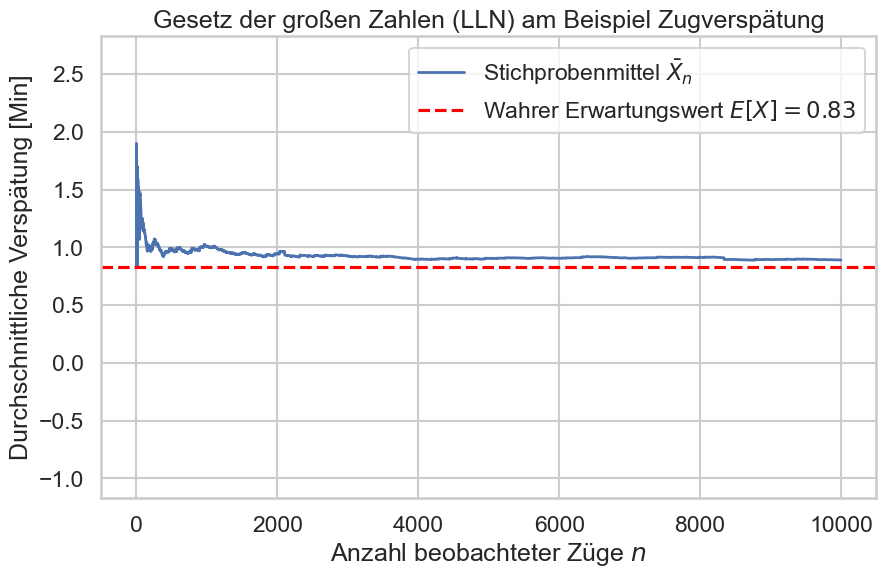

In [38]:
# %% [markdown]
# ## 3. Das Gesetz der großen Zahlen (LLN)
# 
# Die Vorlesung besagt: **"Zufall stabilisiert sich."**
# Wir simulieren dies, indem wir die Daten zufällig mischen und den *laufenden Durchschnitt* (Cumulative Mean) berechnen. Anfangs sollte die Kurve stark schwanken ("Lärm"), dann konvergieren ("Signal").

# %%
# 1. Wir nehmen ein zufälliges Sample (z.B. 10.000 Fahrten), damit der Plot lesbar bleibt
# 2. Wir berechnen den kumulativen Mittelwert Schritt für Schritt
lln_data = df.select("X_delay").sample(10000, shuffle=True, seed=42)

# Berechnung des Cumulative Mean in Polars
# (Summe bis Zeile i) / (Zeilennummer i)
cum_mean = (
    lln_data
    .with_row_index("n")
    .with_columns([
        (pl.col("X_delay").cum_sum() / (pl.col("n") + 1)).alias("running_mean")
    ])
)

# Wahren Erwartungswert (vom gesamten Datensatz) als Referenz
true_mu = df["X_delay"].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cum_mean["n"], cum_mean["running_mean"], lw=2, label="Stichprobenmittel $\\bar{X}_n$")
plt.axhline(true_mu, color='red', linestyle='--', label=f"Wahrer Erwartungswert $E[X] = {true_mu:.2f}$")

plt.title("Gesetz der großen Zahlen (LLN) am Beispiel Zugverspätung")
plt.xlabel("Anzahl beobachteter Züge $n$")
plt.ylabel("Durchschnittliche Verspätung [Min]")
plt.legend()
plt.ylim(true_mu - 2, true_mu + 2) # Zoom auf den Bereich um den Mean
plt.show()

Wahrscheinlichkeit P(X > 5 Min):  1.99%
Wahrscheinlichkeit P(X > 15 Min): 0.20%


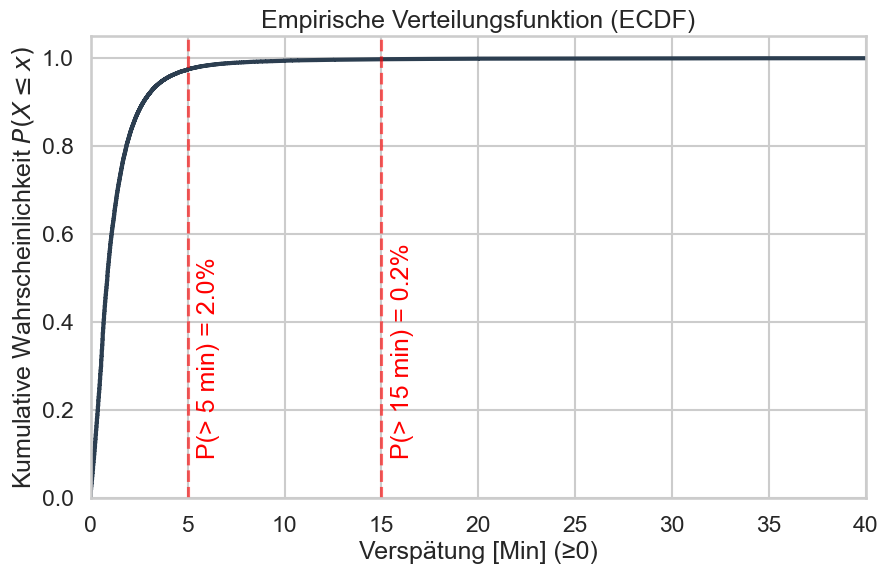

In [39]:
# %% [markdown]
# ## 4. Empirische Verteilungsfunktion (ECDF)
# 
# Wir beantworten die Frage: **"Mit welcher Wahrscheinlichkeit ist mein Zug weniger als X Minuten verspätet?"**

# %%
# Berechnung der KPIs auf den vollen Daten

p_gt5 = (df.filter(pl.col("delay_arrival_s") > 300).height / df.height)
p_gt15 = (df.filter(pl.col("delay_arrival_s") > 900).height / df.height)

print(f"Wahrscheinlichkeit P(X > 5 Min):  {p_gt5:.2%}")
print(f"Wahrscheinlichkeit P(X > 15 Min): {p_gt15:.2%}")

# ECDF Plot (Nur positive Werte für saubere Darstellung)
pos_sample = np.sort(sample_data[sample_data >= 0])
y_vals = np.arange(1, len(pos_sample)+1) / len(pos_sample)

plt.figure(figsize=(10, 6))
plt.plot(pos_sample, y_vals, lw=3, color="#2c3e50")

# Markierungslinien
for t, p in [(5, p_gt5), (15, p_gt15)]:
    plt.axvline(t, color='red', linestyle='--', alpha=0.6)
    # y-Position ist 1 - p, da p die Wahrscheinlichkeit für "Größer als" ist
    plt.text(t + 0.5, 0.1, f"P(> {t} min) = {p:.1%}", color='red', rotation=90)

plt.xlim(0, 40)
plt.ylim(0, 1.05)
plt.xlabel("Verspätung [Min] (≥0)")
# KORREKTUR: \leq statt \le und raw-string r"..."
plt.ylabel(r"Kumulative Wahrscheinlichkeit $P(X \leq x)$")
plt.title("Empirische Verteilungsfunktion (ECDF)")
plt.show()

In [40]:
# %% [markdown]
# ## 5. Risikomasse: Rush Hour vs. Off-Peak
# 
# Wir wenden die Konzepte aus VL5 (Folie 36) an:
# Erhöht die **Rush Hour (E)** das Risiko für eine **Verspätung > 3 Min (D)**?
# 
# Wir berechnen:
# 1.  $P(D|E)$: Risiko in der Rush Hour
# 2.  $P(D|E^c)$: Risiko ausserhalb der Rush Hour
# 3.  **Relative Risk (RR):** $P(D|E) / P(D|E^c)$
# 4.  **Odds Ratio (OR)**

# %%
# Definition des "Krankheitsfalls" D (Hier: Verspätung > 3 Min)
threshold = 3

# Aggregation (Kreuztabelle)
risk_table = (
    df.with_columns((pl.col("X_delay") > threshold).alias("Event_D"))
    .group_by("Is_RushHour") # Das ist unsere Exposition E
    .agg([
        pl.count().alias("Total"),
        pl.col("Event_D").sum().alias("D_Count") # Anzahl verspätet
    ])
    .with_columns((pl.col("D_Count") / pl.col("Total")).alias("Risk_P"))
    .sort("Is_RushHour", descending=True) # True (RushHour) zuerst
)

print("Risiko-Tabelle:")
print(risk_table)

# Extraktion der Werte
# Zeile 0 = Rush Hour (True), Zeile 1 = Off-Peak (False)
p_rush = risk_table["Risk_P"][0]
p_off  = risk_table["Risk_P"][1]

# Berechnung der Metriken aus der Vorlesung
risk_diff = p_rush - p_off
rel_risk  = p_rush / p_off
# Odds = P / (1-P)
odds_rush = p_rush / (1 - p_rush)
odds_off  = p_off / (1 - p_off)
odds_ratio = odds_rush / odds_off

print(f"\n=== Analyse nach VL5 ===")
print(f"Risiko in Rush Hour P(D|E):     {p_rush:.2%}")
print(f"Risiko Off-Peak P(D|Ec):        {p_off:.2%}")
print(f"--------------------------------")
print(f"Risk Difference (Absolut):      {risk_diff:+.2%} (Prozentpunkte mehr)")
print(f"Relative Risk (RR):             {rel_risk:.2f}x  (Faktor)")
print(f"Odds Ratio (OR):                {odds_ratio:.2f}")

if rel_risk > 1:
    print(f"\nFazit: In der Rush Hour ist das Risiko einer Verspätung >{threshold} Min um das {rel_risk:.2f}-fache erhöht.")

Risiko-Tabelle:
shape: (2, 4)
┌─────────────┬─────────┬─────────┬──────────┐
│ Is_RushHour ┆ Total   ┆ D_Count ┆ Risk_P   │
│ ---         ┆ ---     ┆ ---     ┆ ---      │
│ bool        ┆ u32     ┆ u32     ┆ f64      │
╞═════════════╪═════════╪═════════╪══════════╡
│ true        ┆ 1421883 ┆ 114236  ┆ 0.080341 │
│ false       ┆ 3193257 ┆ 179267  ┆ 0.056139 │
└─────────────┴─────────┴─────────┴──────────┘

=== Analyse nach VL5 ===
Risiko in Rush Hour P(D|E):     8.03%
Risiko Off-Peak P(D|Ec):        5.61%
--------------------------------
Risk Difference (Absolut):      +2.42% (Prozentpunkte mehr)
Relative Risk (RR):             1.43x  (Faktor)
Odds Ratio (OR):                1.47

Fazit: In der Rush Hour ist das Risiko einer Verspätung >3 Min um das 1.43-fache erhöht.


/var/folders/gj/srqb2sgx1v17z_n4r5sd1hz00000gn/T/ipykernel_8696/1898374800.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("Total"),


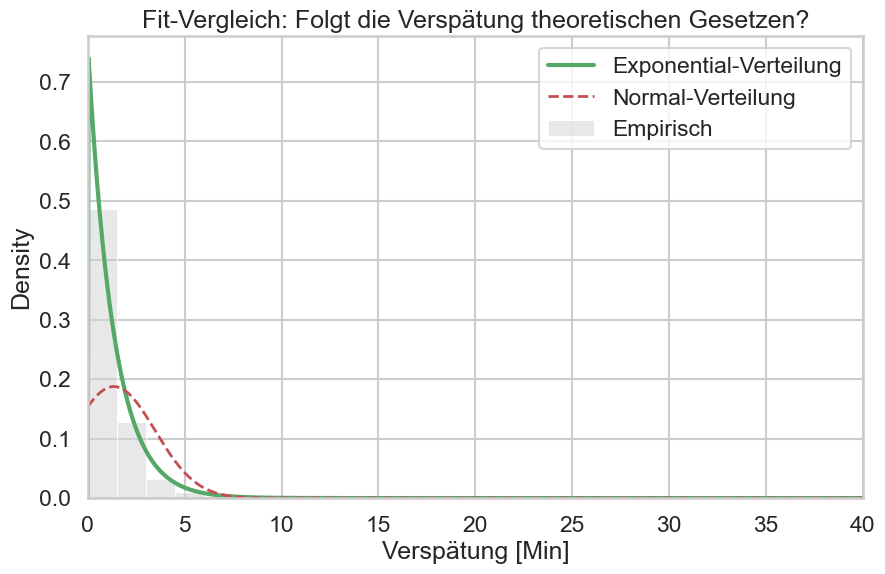

Interpretation: Die Exponentialverteilung (grün) sollte den steilen Abfall der Kurve besser treffen als die Glockenkurve (rot).


In [41]:
# %% [markdown]
# ## 6. Vergleich mit theoretischen Verteilungen
# 
# Laut Vorlesung eignet sich die **Exponentialverteilung** oft für Wartezeiten. Die **Normalverteilung** setzt Symmetrie voraus (was wir nicht haben).
# Wir testen dies am positiven Schweif der Verteilung ($X > 0$).

# %%
# Nur positive Verspätungen für den Fit (Exponential ist für x >= 0 definiert)
data_fit = x_sample[x_sample > 0]

# Parameter schätzen (Maximum Likelihood Estimation)
loc_exp, scale_exp = stats.expon.fit(data_fit)
mu_norm, std_norm = stats.norm.fit(data_fit)

# x-Achse für die theoretischen Kurven
x = np.linspace(0, 40, 1000)

plt.figure(figsize=(10, 6))
# 1. Empirische Daten
sns.histplot(data_fit, bins=80, stat="density", color="lightgrey", label="Empirisch", alpha=0.5)

# 2. Exponential (Theorie)
plt.plot(x, stats.expon.pdf(x, loc_exp, scale_exp), 'g-', lw=3, label="Exponential-Verteilung")

# 3. Normal (Theorie)
plt.plot(x, stats.norm.pdf(x, mu_norm, std_norm), 'r--', lw=2, label="Normal-Verteilung")

plt.xlim(0, 40)
plt.title("Fit-Vergleich: Folgt die Verspätung theoretischen Gesetzen?")
plt.xlabel("Verspätung [Min]")
plt.legend()
plt.show()

print("Interpretation: Die Exponentialverteilung (grün) sollte den steilen Abfall der Kurve besser treffen als die Glockenkurve (rot).")

<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\l'
/var/folders/gj/srqb2sgx1v17z_n4r5sd1hz00000gn/T/ipykernel_8696/1204518104.py:38: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(x_k, y_poisson, 'bo-', lw=2, label=f"Poisson-Theorie ($\lambda={lambda_est:.1f}$)")


Geschätztes Lambda (Ø Verspätungen >5 Min pro Stunde): 135.05


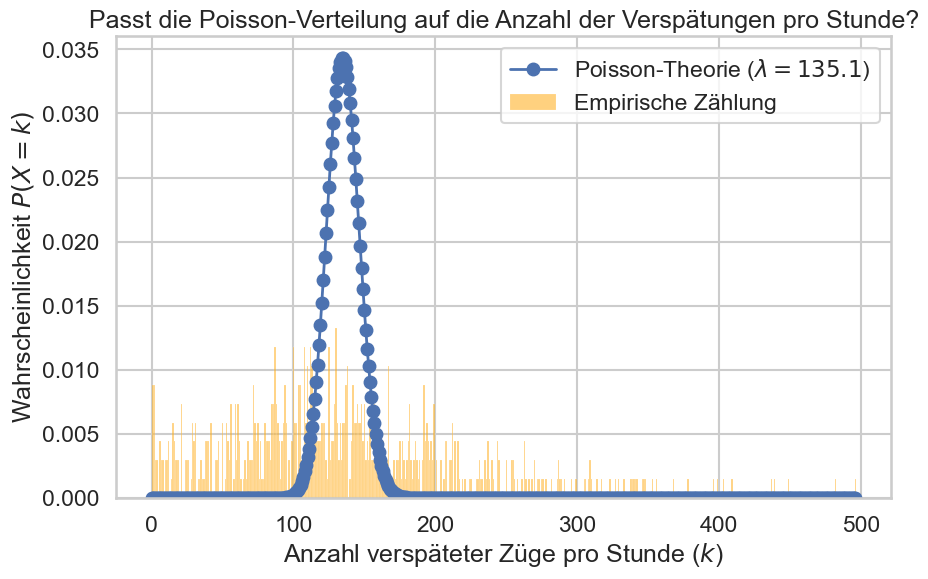

In [42]:
# %% [markdown]
# ## 7. Diskrete Verteilungen (Poisson)
# 
# Die Vorlesung erwähnt die **Poisson-Verteilung** für seltene Ereignisse in einem Intervall (z.B. "Anzahl Störungen pro Tag").
# Wir testen: Folgt die **Anzahl der Züge mit >5 Min Verspätung pro Stunde** einer Poisson-Verteilung?
# 
# * **Lambda ($\lambda$):** Durchschnittliche Anzahl Events pro Stunde.

# %%
# 1. Daten aggregieren: Anzahl "stark verspäteter" Züge pro Stunde
# Wir nutzen dazu Datum + Stunde als Gruppierung
poisson_df = (
    df.with_columns([
        (pl.col("delay_arrival_s") > 300).alias("Is_Late"),
        pl.col("BETRIEBSTAG").dt.date().alias("Date"),
        pl.col("ANKUNFTSZEIT").dt.hour().alias("Hour")
    ])
    .filter(pl.col("Is_Late") == True) # Nur die verspäteten betrachten
    .group_by(["Date", "Hour"])
    .agg(pl.len().alias("Count_Late")) # Zähle Vorkommnisse pro Stunde
)

# 2. Lambda schätzen (Mittelwert der Counts)
counts = poisson_df["Count_Late"].to_numpy()
lambda_est = counts.mean()

print(f"Geschätztes Lambda (Ø Verspätungen >5 Min pro Stunde): {lambda_est:.2f}")

# 3. Plotting: Empirisch vs. Theoretisch (Poisson)
x_k = np.arange(0, counts.max() + 1)
# Poisson PMF (Probability Mass Function)
y_poisson = stats.poisson.pmf(x_k, mu=lambda_est)

plt.figure(figsize=(10, 6))
# Empirisch (Balken)
sns.histplot(counts, stat="density", discrete=True, color="orange", alpha=0.5, label="Empirische Zählung")
# Theorie (Punkte/Linie)
plt.plot(x_k, y_poisson, 'bo-', lw=2, label=f"Poisson-Theorie ($\lambda={lambda_est:.1f}$)")

plt.title("Passt die Poisson-Verteilung auf die Anzahl der Verspätungen pro Stunde?")
plt.xlabel("Anzahl verspäteter Züge pro Stunde ($k$)")
plt.ylabel("Wahrscheinlichkeit $P(X=k)$")
plt.legend()
plt.show()

In [43]:
# %% [markdown]
# ## 8. Das Simpson-Paradoxon
# 
# Nach VL5 (Folie 38) kann eine aggregierte Sicht täuschen.
# Wir simulieren einen Check: Gibt es einen Betreiber, der global "schlechter" wirkt, aber nur weil er öfter zu schwierigen Zeiten (Rush Hour) fährt?
# 
# Wir vergleichen die Pünktlichkeit ($P(X \le 3)$) der zwei **größten** Betreiber:
# 1.  **Global** (aggregiert).
# 2.  **Stratifiziert** nach Rush Hour (ja/nein).

# %%
# 1. Die zwei wirklich größten Betreiber identifizieren (mit Sortierung!)
# Hinweis: Polars value_counts() sortiert nicht automatisch.
top_2_ops = (
    df["BETREIBER_NAME"]
    .value_counts()
    .sort("count", descending=True)
    .head(2)
    ["BETREIBER_NAME"]
    .to_list()
)
print(f"Vergleich für Simpson-Check (Top 2): {top_2_ops}")

# 2. Daten filtern und Pünktlichkeit berechnen (Grenze: 3 Min)
simpson_df = (
    df.filter(pl.col("BETREIBER_NAME").is_in(top_2_ops))
    .with_columns((pl.col("delay_arrival_s") <= 180).alias("Is_Punctual"))
)

# 3. Globale Sicht (Aggregiert)
global_view = (
    simpson_df.group_by("BETREIBER_NAME")
    .agg(pl.col("Is_Punctual").mean().alias("Punctuality_Global"))
    .sort("BETREIBER_NAME")
)

# 4. Stratifizierte Sicht (nach Rush Hour)
stratified_view = (
    simpson_df.group_by(["BETREIBER_NAME", "Is_RushHour"])
    .agg(pl.col("Is_Punctual").mean().alias("Punctuality_Stratified"))
    .sort(["BETREIBER_NAME", "Is_RushHour"])
)

print("\n--- Globale Pünktlichkeit ---")
print(global_view)
print("\n--- Pünktlichkeit Stratifiziert (Rush Hour vs. Off-Peak) ---")
print(stratified_view)

print("\nAnalyse: Ein Simpson-Paradoxon liegt vor, wenn Betreiber A global schlechter ist, aber in BEIDEN Gruppen (Rush Hour & Off-Peak) besser als Betreiber B abschneidet.")

Vergleich für Simpson-Check (Top 2): ['Schweizerische Bundesbahnen SBB', 'BLS AG (bls)']

--- Globale Pünktlichkeit ---
shape: (2, 2)
┌─────────────────────────────────┬────────────────────┐
│ BETREIBER_NAME                  ┆ Punctuality_Global │
│ ---                             ┆ ---                │
│ str                             ┆ f64                │
╞═════════════════════════════════╪════════════════════╡
│ BLS AG (bls)                    ┆ 0.956256           │
│ Schweizerische Bundesbahnen SB… ┆ 0.936615           │
└─────────────────────────────────┴────────────────────┘

--- Pünktlichkeit Stratifiziert (Rush Hour vs. Off-Peak) ---
shape: (4, 3)
┌─────────────────────────────────┬─────────────┬────────────────────────┐
│ BETREIBER_NAME                  ┆ Is_RushHour ┆ Punctuality_Stratified │
│ ---                             ┆ ---         ┆ ---                    │
│ str                             ┆ bool        ┆ f64                    │
╞═════════════════════════════════

/var/folders/gj/srqb2sgx1v17z_n4r5sd1hz00000gn/T/ipykernel_8696/774245964.py:42: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(


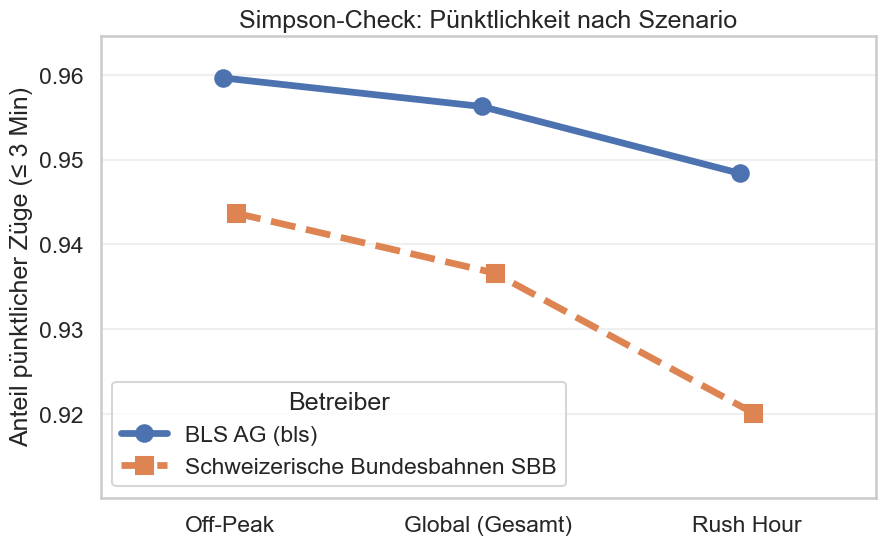

In [46]:
# %% [markdown]
# ### 8.1 Visualisierung: Gibt es gekreuzte Trends?
# 
# Wir bereiten die Daten in Polars auf und visualisieren sie.
# *Interpretation:* Kreuzende Linien = Simpson-Paradoxon. Parallele Linien = Robustes Ergebnis.

# %%
# 1. Aufbereitung der Stratifizierten Daten (in Polars)
plot_data_pl = (
    stratified_view
    .with_columns(
        pl.when(pl.col("Is_RushHour"))
        .then(pl.lit("Rush Hour"))
        .otherwise(pl.lit("Off-Peak"))
        .alias("Kategorie")
    )
    .rename({"Punctuality_Stratified": "Pünktlichkeit"})
    .select(["BETREIBER_NAME", "Kategorie", "Pünktlichkeit"])
)

# 2. Aufbereitung der Globalen Daten (in Polars)
global_pl = (
    global_view
    .with_columns(
        pl.lit("Global (Gesamt)").alias("Kategorie")
    )
    .rename({"Punctuality_Global": "Pünktlichkeit"})
    .select(["BETREIBER_NAME", "Kategorie", "Pünktlichkeit"])
)

# 3. Zusammenfügen (Polars Concat)
# Polars concat benötigt kein 'ignore_index', es hängt einfach an
final_plot_df = pl.concat([plot_data_pl, global_pl])

# 4. Konvertierung zu Pandas NUR für den Plot
plot_df_pandas = final_plot_df.to_pandas()

# Plotting
plt.figure(figsize=(10, 6))
category_order = ["Off-Peak", "Global (Gesamt)", "Rush Hour"]

sns.pointplot(
    data=plot_df_pandas,
    x="Kategorie",
    y="Pünktlichkeit",
    hue="BETREIBER_NAME",
    order=category_order,
    dodge=True,
    markers=["o", "s"],
    linestyles=["-", "--"],
    scale=1.2
)

plt.title("Simpson-Check: Pünktlichkeit nach Szenario")
plt.ylabel("Anteil pünktlicher Züge (≤ 3 Min)")
plt.xlabel("")
plt.legend(title="Betreiber", loc="best")
plt.grid(True, axis='y', alpha=0.3)

# Y-Achse zoomen
y_min = plot_df_pandas["Pünktlichkeit"].min() - 0.01
y_max = plot_df_pandas["Pünktlichkeit"].max() + 0.005
plt.ylim(y_min, y_max)

plt.show()